<a href="https://colab.research.google.com/github/shabnomm/Alzheimer-s-MRI-ADNI-OASIS-/blob/main/Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install -q torch torchvision opencv-python matplotlib seaborn albumentations grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.3 MB/s e

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving alzheimer.zip to alzheimer.zip


In [ ]:
!unzip -q alzheimer.zip -d alzheimer_data


In [ ]:
import os

base_path = 'alzheimer_data'
for root, dirs, files in os.walk(base_path):
    print(f"📁 {root} → {len(files)} files")
    for d in dirs:
        print(f" ┗━ 📂 {d}")
    break  # Show only the top level


📁 alzheimer_data → 0 files
 ┗━ 📂 Combined Dataset


In [ ]:
import os

dataset_path = "alzheimer_data/Combined Dataset"
class_folders = os.listdir(dataset_path)

print("📂 Classes in dataset:")
for folder in class_folders:
    print(" ┗━", folder)


📂 Classes in dataset:
 ┗━ test
 ┗━ train


In [ ]:
import os

train_path = "alzheimer_data/Combined Dataset/train"
test_path = "alzheimer_data/Combined Dataset/test"

print("🔍 Train Set Classes:")
for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f" ┗━ {cls}: {num_images} images")

print("\n🔍 Test Set Classes:")
for cls in os.listdir(test_path):
    cls_path = os.path.join(test_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f" ┗━ {cls}: {num_images} images")


🔍 Train Set Classes:
 ┗━ Mild Impairment: 2560 images
 ┗━ Very Mild Impairment: 2560 images
 ┗━ Moderate Impairment: 2560 images
 ┗━ No Impairment: 2560 images

🔍 Test Set Classes:
 ┗━ Mild Impairment: 179 images
 ┗━ Very Mild Impairment: 448 images
 ┗━ Moderate Impairment: 12 images
 ┗━ No Impairment: 640 images


In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib seaborn scikit-learn grad-cam --quiet


Data Prepoccessing


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define directories
train_dir = 'alzheimer_data/Combined Dataset/train'
test_dir = 'alzheimer_data/Combined Dataset/test'

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print(f"✅ Found classes: {class_names}")


✅ Found classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


# Transfer Learning Model (ResNet18)


1.   Load ResNet18 pretrained on ImageNet

2.   Replace the classifier head to fit 4 output classes

3.   Use CrossEntropyLoss with weighted class balancing
4. Use Adam optimizer








In [ ]:
import torch.nn as nn
import torchvision.models as models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ResNet18
model = models.resnet18(pretrained=True)

# Freeze earlier layers (optional for speed)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

# Compute class weights to handle imbalance
targets = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(targets),
                                     y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]



#Model Building

In [ ]:
import os
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


##Define Transformations and Load Data

In [ ]:
# Image size for ResNet
IMAGE_SIZE = 224

# Transformations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Path Setup
train_dir = "/content/alzheimer_data/Combined Dataset/train"
test_dir = "/content/alzheimer_data/Combined Dataset/test"

# Load Dataset
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class labels
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


##Load Pretrained ResNet18 and Modify for 4 Classes

In [ ]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze feature extractor (optional — we’ll train only the last layer first)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 4)  # 4 classes
)

model = model.to(device)


##Define Loss, Optimizer, and Scheduler

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Only train the new classifier layers
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


##Model Training Loop

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to eval mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.upper()} LOSS: {epoch_loss:.4f} | ACC: {epoch_acc:.4f}")

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"\n✅ Best VAL ACC: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


##Dataloader

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

class AlzheimerDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.dataset = image_folder_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL to numpy
        if self.transform:
            augmented = self.transform(image=image)  # pass as keyword argument
            image = augmented['image']
        return image, label


# 📌 Image Transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
}


# 📁 Dataset Path
train_dir = '/content/alzheimer_data/Combined Dataset/train'

# 📌 Load Full Dataset (split later)
full_dataset = datasets.ImageFolder(train_dir, transform=image_transforms['train'])

# 🔀 Split into Train and Val (80-20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply val transforms to val split
val_dataset.dataset.transform = image_transforms['val']

# ✅ Create Dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
}

# 🔍 Class names (for future use)
class_names = full_dataset.classes


In [ ]:
trained_model = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10)



📅 Epoch 1/10
------------------------------
TRAIN LOSS: 0.7734 | ACC: 0.6691
VAL LOSS: 0.5374 | ACC: 0.7705

📅 Epoch 2/10
------------------------------
TRAIN LOSS: 0.5980 | ACC: 0.7390
VAL LOSS: 0.4892 | ACC: 0.7798

📅 Epoch 3/10
------------------------------
TRAIN LOSS: 0.5586 | ACC: 0.7510
VAL LOSS: 0.5202 | ACC: 0.7681

📅 Epoch 4/10
------------------------------
TRAIN LOSS: 0.5204 | ACC: 0.7714
VAL LOSS: 0.4516 | ACC: 0.7959

📅 Epoch 5/10
------------------------------
TRAIN LOSS: 0.5093 | ACC: 0.7689
VAL LOSS: 0.4393 | ACC: 0.8062

📅 Epoch 6/10
------------------------------
TRAIN LOSS: 0.4584 | ACC: 0.7933
VAL LOSS: 0.4248 | ACC: 0.8013

📅 Epoch 7/10
------------------------------
TRAIN LOSS: 0.4435 | ACC: 0.8009
VAL LOSS: 0.4195 | ACC: 0.8086

📅 Epoch 8/10
------------------------------
TRAIN LOSS: 0.4398 | ACC: 0.8041
VAL LOSS: 0.4209 | ACC: 0.8018

📅 Epoch 9/10
------------------------------
TRAIN LOSS: 0.4378 | ACC: 0.8063
VAL LOSS: 0.4150 | ACC: 0.8105

📅 Epoch 10/10
----

## Unfreeze Entire Model for Training

In [ ]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Redefine optimizer to train all parameters with a smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
!pip install albumentations --quiet


##Use Albumentations for Advanced Augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


/tmp/ipython-input-3381054220.py:8: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


##Update Dataset and Dataloaders to Use Albumentations

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class AlzheimerDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.dataset = image_folder_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label


In [ ]:
# Load base dataset without transforms
full_dataset = datasets.ImageFolder(train_dir)

# Split train/val as before
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_base, val_base = random_split(full_dataset, [train_size, val_size])

# Wrap in custom dataset with albumentations
train_dataset = AlzheimerDataset(train_base, transform=train_transform)
val_dataset = AlzheimerDataset(val_base, transform=val_transform)

# Dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
}


##Retrain Model

In [ ]:
trained_model = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=15)



📅 Epoch 1/15
------------------------------
TRAIN LOSS: 0.0876 | ACC: 0.9683
VAL LOSS: 0.1101 | ACC: 0.9556

📅 Epoch 2/15
------------------------------
TRAIN LOSS: 0.0974 | ACC: 0.9647
VAL LOSS: 0.0277 | ACC: 0.9902

📅 Epoch 3/15
------------------------------
TRAIN LOSS: 0.0693 | ACC: 0.9735
VAL LOSS: 0.0349 | ACC: 0.9863

📅 Epoch 4/15
------------------------------
TRAIN LOSS: 0.0713 | ACC: 0.9760
VAL LOSS: 0.0441 | ACC: 0.9854

📅 Epoch 5/15
------------------------------
TRAIN LOSS: 0.0580 | ACC: 0.9792
VAL LOSS: 0.0243 | ACC: 0.9917

📅 Epoch 6/15
------------------------------
TRAIN LOSS: 0.0531 | ACC: 0.9822
VAL LOSS: 0.0709 | ACC: 0.9717

📅 Epoch 7/15
------------------------------
TRAIN LOSS: 0.0668 | ACC: 0.9764
VAL LOSS: 0.0303 | ACC: 0.9902

📅 Epoch 8/15
------------------------------
TRAIN LOSS: 0.0512 | ACC: 0.9822
VAL LOSS: 0.0178 | ACC: 0.9937

📅 Epoch 9/15
------------------------------
TRAIN LOSS: 0.0517 | ACC: 0.9817
VAL LOSS: 0.0194 | ACC: 0.9946

📅 Epoch 10/15
----

In [ ]:
test_base = datasets.ImageFolder(test_dir)  # No transform here
test_dataset = AlzheimerDataset(test_base, transform=image_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

# 1. 📁 Load base test dataset WITHOUT transforms
test_dir = '/content/alzheimer_data/Combined Dataset/test'
test_base = datasets.ImageFolder(test_dir)  # ⚠️ No transform here

# 2. 🧠 Wrap in custom AlzheimerDataset to apply Albumentations
test_dataset = AlzheimerDataset(test_base, transform=val_transform)

# 3. 🌀 Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

all_preds = []
all_labels = []

trained_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🧾 Labels must match your dataset's class order
class_names = test_base.classes  # safer than manually writing names

print(f"\nTest Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Test Accuracy: 0.9812

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.98      0.98       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.98      0.99      0.98       640
Very Mild Impairment       0.98      0.97      0.98       448

            accuracy                           0.98      1279
           macro avg       0.99      0.98      0.99      1279
        weighted avg       0.98      0.98      0.98      1279



In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14,5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    best_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f"\n📅 Epoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.upper()} LOSS: {epoch_loss:.4f} | ACC: {epoch_acc:.4f}")

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        if scheduler:
            scheduler.step()

    print(f"\n✅ Best VAL ACCURACY: {best_acc:.4f}")

    # Load best model weights before returning
    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
trained_model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=15)



📅 Epoch 1/15
------------------------------
TRAIN LOSS: 0.0440 | ACC: 0.9843
VAL LOSS: 0.0630 | ACC: 0.9766

📅 Epoch 2/15
------------------------------
TRAIN LOSS: 0.0387 | ACC: 0.9879
VAL LOSS: 0.0146 | ACC: 0.9961

📅 Epoch 3/15
------------------------------
TRAIN LOSS: 0.0388 | ACC: 0.9869
VAL LOSS: 0.0501 | ACC: 0.9819

📅 Epoch 4/15
------------------------------
TRAIN LOSS: 0.0408 | ACC: 0.9871
VAL LOSS: 0.0342 | ACC: 0.9878

📅 Epoch 5/15
------------------------------
TRAIN LOSS: 0.0444 | ACC: 0.9852
VAL LOSS: 0.0385 | ACC: 0.9873

📅 Epoch 6/15
------------------------------
TRAIN LOSS: 0.0337 | ACC: 0.9884
VAL LOSS: 0.0488 | ACC: 0.9844

📅 Epoch 7/15
------------------------------
TRAIN LOSS: 0.0293 | ACC: 0.9906
VAL LOSS: 0.0222 | ACC: 0.9937

📅 Epoch 8/15
------------------------------
TRAIN LOSS: 0.0291 | ACC: 0.9895
VAL LOSS: 0.0217 | ACC: 0.9912

📅 Epoch 9/15
------------------------------
TRAIN LOSS: 0.0316 | ACC: 0.9901
VAL LOSS: 0.0451 | ACC: 0.9878

📅 Epoch 10/15
----

In [ ]:
test_base = datasets.ImageFolder(test_dir)  # No transform here
test_dataset = AlzheimerDataset(test_base, transform=image_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

all_preds = []
all_labels = []

trained_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🧾 Labels must match your dataset's class order
class_names = test_base.classes  # safer than manually writing names

print(f"\nTest Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Test Accuracy: 0.9836

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.99      0.99       179
 Moderate Impairment       0.92      1.00      0.96        12
       No Impairment       0.98      1.00      0.99       640
Very Mild Impairment       1.00      0.96      0.98       448

            accuracy                           0.98      1279
           macro avg       0.97      0.99      0.98      1279
        weighted avg       0.98      0.98      0.98      1279



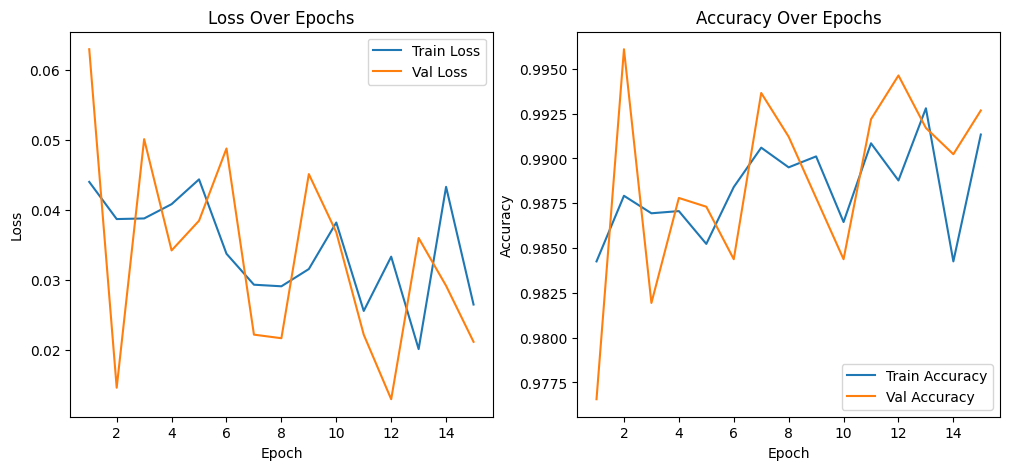

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.show()

plot_training_history(history)


In [ ]:
# Save the model state dict
torch.save(trained_model.state_dict(), 'alzheimer_model.pth')
print("Model saved successfully!")


Model saved successfully!


##Grad-CAM Utility Class

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        self.hook_handles = []

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        weighted_activations = self.activations[0] * pooled_gradients[:, None, None]
        heatmap = torch.sum(weighted_activations, dim=0).cpu()

        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()


In [ ]:
# Choose a test image (you can load from dataset or path)
img_path = r"C:\Users\User\Desktop\alzheimer\Combined Dataset\test\Moderate Impairment\16 (2).jpg"

# Load and transform the image
original_img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

transform = val_transform  # albumentations transform
augmented = transform(image=img_rgb)
input_tensor = augmented["image"].unsqueeze(0).to(device)


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import os

img_path = r"C:\Users\User\Desktop\alzheimer\Combined Dataset\test\Moderate Impairment\14.jpg"
print("Image exists?", os.path.exists(img_path))


Image exists? False
